In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import pickle
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                            f1_score,accuracy_score, precision_score, 
                             recall_score, roc_auc_score) 
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAvgPool1D
import tensorflow as tf

In [36]:
df = pd.read_csv(r"C:\Users\Simplon\Desktop\Travaux python\Texte analyze\Sentiment analyses\women clothing reviews\Womens Clothing E-Commerce Reviews.csv")

In [37]:
df = df.drop(['Unnamed: 0','Title', 'Clothing ID', 'Positive Feedback Count'], axis=1)
df.head()

,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates
1,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses
2,60,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants
4,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses


In [39]:
a = df['Review Text'].iloc[0]

In [40]:
a

'Absolutely wonderful - silky and sexy and comfortable'

In [41]:
df = df.dropna(subset=['Review Text', 'Division Name', 'Department Name', 'Class Name'], axis=0)
df = df.reset_index(drop=True)

# Data preprocessing

In [42]:
df['Review Text'] = df['Review Text'].str.lower()
df['Review Text'].head()

0    absolutely wonderful - silky and sexy and comf...
1    love this dress!  it's sooo pretty.  i happene...
2    i had such high hopes for this dress and reall...
3    i love, love, love this jumpsuit. it's fun, fl...
4    this shirt is very flattering to all due to th...
Name: Review Text, dtype: object

In [44]:
def remove_punctuations_numbers(inputs):
    return re.sub(r'[^a-zA-Z]', ' ', inputs)


df['Review Text'] = df['Review Text'].apply(remove_punctuations_numbers)

In [45]:
def tokenization(inputs):  # Ref.1
    return word_tokenize(inputs)


df['text_tokenized'] = df['Review Text'].apply(tokenization)
df['text_tokenized'].head()

0    [absolutely, wonderful, silky, and, sexy, and,...
1    [love, this, dress, it, s, sooo, pretty, i, ha...
2    [i, had, such, high, hopes, for, this, dress, ...
3    [i, love, love, love, this, jumpsuit, it, s, f...
4    [this, shirt, is, very, flattering, to, all, d...
Name: text_tokenized, dtype: object

In [46]:
stop_words = set(stopwords.words('english'))
stop_words.remove('not')


def stopwords_remove(inputs):  # Ref.2
    return [k for k in inputs if k not in stop_words]


df['text_stop'] = df['text_tokenized'].apply(stopwords_remove)
df['text_stop'].head()

0    [absolutely, wonderful, silky, sexy, comfortable]
1    [love, dress, sooo, pretty, happened, find, st...
2    [high, hopes, dress, really, wanted, work, ini...
3    [love, love, love, jumpsuit, fun, flirty, fabu...
4    [shirt, flattering, due, adjustable, front, ti...
Name: text_stop, dtype: object

In [47]:
lemmatizer = WordNetLemmatizer()


def lemmatization(inputs):  # Ref.1
    return [lemmatizer.lemmatize(word=kk, pos='v') for kk in inputs]


df['text_lemmatized'] = df['text_stop'].apply(lemmatization)
df['text_lemmatized'].head()

0    [absolutely, wonderful, silky, sexy, comfortable]
1    [love, dress, sooo, pretty, happen, find, stor...
2    [high, hop, dress, really, want, work, initial...
3    [love, love, love, jumpsuit, fun, flirty, fabu...
4    [shirt, flatter, due, adjustable, front, tie, ...
Name: text_lemmatized, dtype: object

In [48]:
# Removing Words less than length 2
def remove_less_than_2(inputs):  # Ref.1
    return [j for j in inputs if len(j) > 2]


df['final'] = df['text_lemmatized'].apply(remove_less_than_2)

In [49]:
# Joining Tokens into Sentences
df['final'] = df['final'].str.join(' ')
df['final'].head()

0          absolutely wonderful silky sexy comfortable
1    love dress sooo pretty happen find store glad ...
2    high hop dress really want work initially orde...
3    love love love jumpsuit fun flirty fabulous ev...
4    shirt flatter due adjustable front tie perfect...
Name: final, dtype: object

In [50]:
df['final'].iloc[0]

'absolutely wonderful silky sexy comfortable'

In [12]:
# FreqOfWords = df['final'].str.split(expand=True).stack().value_counts()
# FreqOfWords_top200 = FreqOfWords[:200]

# fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0)
# fig.update_layout(title_text='Top Frequent 200 Words in the Dataset (After Cleaning)',
#                   title_x=0.5, title_font=dict(size=20)
#                   )
# fig.update_traces(textinfo="label+value")
# fig.show()

# Worldcloud

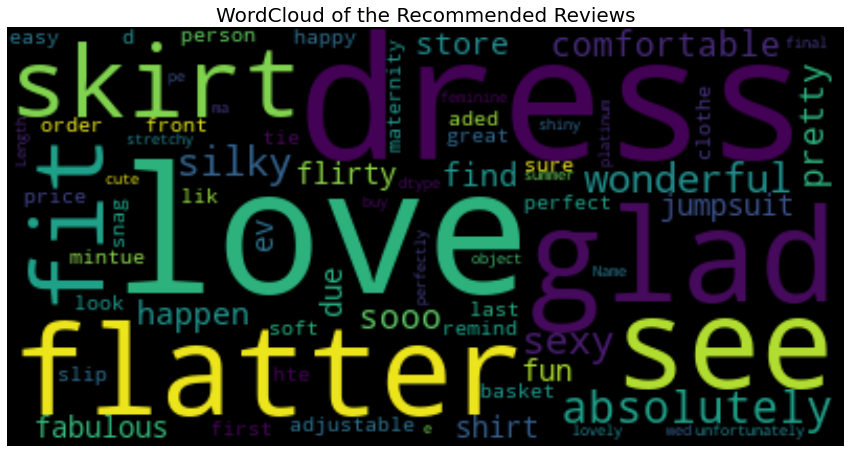

In [13]:
data_recommended = df[df['Recommended IND'] == 1]  # Dataframe that only includes recommended reviews
data_not_recommended = df[df['Recommended IND'] == 0]  # # Dataframe that only includes not recommended reviews

WordCloud_recommended = WordCloud(max_words=500,
                                  random_state=30,
                                  collocations=True).generate(str((data_recommended['final'])))

plt.figure(figsize=(15, 8))
plt.imshow(WordCloud_recommended, interpolation='bilinear')
plt.title('WordCloud of the Recommended Reviews', fontsize=20)
plt.axis("off")
plt.show()

# Train test 

In [14]:
y = df['Recommended IND']
X = df['final']

X.head()

0          absolutely wonderful silky sexy comfortable
1    love dress sooo pretty happen find store glad ...
2    high hop dress really want work initially orde...
3    love love love jumpsuit fun flirty fabulous ev...
4    shirt flatter due adjustable front tie perfect...
Name: final, dtype: object

In [15]:
# Train-Test-Validation Split
x, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=13)  # Test: %20

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.25, random_state=13)  # Val: %20

print('Shape of the X_train:', X_train.shape)
print('Shape of the X_test:', X_test.shape)
print('Shape of the X_val:', X_val.shape)
print('--'*20)
print('Shape of the y_train:', y_train.shape)
print('Shape of the y_test:', y_test.shape)
print('Shape of the y_val:', y_val.shape)

Shape of the X_train: (13576,)
Shape of the X_test: (4526,)
Shape of the X_val: (4526,)
----------------------------------------
Shape of the y_train: (13576,)
Shape of the y_test: (4526,)
Shape of the y_val: (4526,)


In [54]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

Tokenized_train = tokenizer.texts_to_sequences(X_train)
Tokenized_val = tokenizer.texts_to_sequences(X_val)

print('Non-tokenized Version: ', X_train[0])
print('Tokenized Version: ', tokenizer.texts_to_sequences([X_train[0]]))
print('--'*20)
print('Non-tokenized Version: ', X_train[80])
print('Tokenized Version: ', tokenizer.texts_to_sequences([X_train[80]]))

Non-tokenized Version:  absolutely wonderful silky sexy comfortable
Tokenized Version:  [[161, 366, 748, 445, 33]]
----------------------------------------
Non-tokenized Version:  usually petite since dress not come petites try fit lbs dress hit knee hem bite not overwhelm dress look stun great vibrant color dark hair make classic elegant dress look contemporary stylish try store salesperson others happen see rave tell grab glad plan wear spring daughte
Tokenized Version:  [[61, 47, 150, 2, 7, 109, 769, 23, 3, 68, 2, 146, 269, 223, 38, 7, 746, 2, 8, 397, 12, 356, 11, 278, 1025, 18, 342, 459, 2, 8, 2151, 344, 23, 57, 1885, 350, 601, 62, 1723, 432, 631, 218, 313, 6, 212, 6315]]


[30,
 149,
 60,
 282,
 164,
 323,
 1290,
 1441,
 430,
 118,
 19,
 27,
 105,
 138,
 125,
 145,
 5,
 384,
 65,
 63,
 8,
 2,
 327,
 64,
 159,
 178,
 25,
 3,
 1004,
 141,
 271,
 669,
 135,
 11,
 10,
 88,
 72,
 13]

In [17]:
maxlen = 50
Padded_train = pad_sequences(Tokenized_train, maxlen=maxlen, padding='pre')
Padded_val = pad_sequences(Tokenized_val, maxlen=maxlen, padding='pre')

In [53]:
Padded_val[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         59,    5,    2,   11,  121,  134,    5,  949,  195,  128,  129,
         91,  199,  184,   53,   21, 2914])

# Embedding Model

In [18]:
# Creating the Model
model = Sequential()

model.add(Embedding(num_words, 16, input_length=maxlen))
model.add(Dropout(0.2))

model.add(GlobalAvgPool1D())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

opt = tf.optimizers.Adam(learning_rate=0.55e-3)  # Learning Rate

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 dropout (Dropout)           (None, 50, 16)            0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
__________________________________________________

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', patience=5,
                                                  restore_best_weights=True)

epochs = 100
hist = model.fit(Padded_train, y_train, epochs=epochs,
                 validation_data=(Padded_val, y_val),
                 callbacks=[early_stopping], batch_size=32)

Epoch 1/100
425/425 [==============================] - 3s 5ms/step - loss: 0.5606 - accuracy: 0.8173 - val_loss: 0.4679 - val_accuracy: 0.8239
Epoch 2/100
425/425 [==============================] - 2s 4ms/step - loss: 0.4672 - accuracy: 0.8201 - val_loss: 0.4411 - val_accuracy: 0.8239
Epoch 3/100
425/425 [==============================] - 2s 4ms/step - loss: 0.4480 - accuracy: 0.8201 - val_loss: 0.4251 - val_accuracy: 0.8239
Epoch 4/100
425/425 [==============================] - 2s 4ms/step - loss: 0.4311 - accuracy: 0.8201 - val_loss: 0.4087 - val_accuracy: 0.8239
Epoch 5/100
425/425 [==============================] - 2s 5ms/step - loss: 0.4129 - accuracy: 0.8202 - val_loss: 0.3906 - val_accuracy: 0.8243
Epoch 6/100
425/425 [==============================] - 2s 6ms/step - loss: 0.3917 - accuracy: 0.8207 - val_loss: 0.3717 - val_accuracy: 0.8250
Epoch 7/100
425/425 [==============================] - 2s 5ms/step - loss: 0.3714 - accuracy: 0.8237 - val_loss: 0.3517 - val_accuracy: 0.8312

# evaluating model

In [20]:
X_test = X_test.apply(tokenization)
X_test = X_test.apply(stopwords_remove)
X_test = X_test.apply(lemmatization)
X_test = X_test.str.join(' ')

In [21]:
Tokenized_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(Tokenized_test, maxlen=maxlen, padding='pre')

In [22]:
pred_train_lstm = model.predict(Padded_train)
pred_test_lstm = model.predict(padded_test)

In [23]:
pred_test_lstm

array([[0.7200498 ],
       [0.12526181],
       [0.9871051 ],
       ...,
       [0.99960977],
       [0.9966387 ],
       [0.98549294]], dtype=float32)

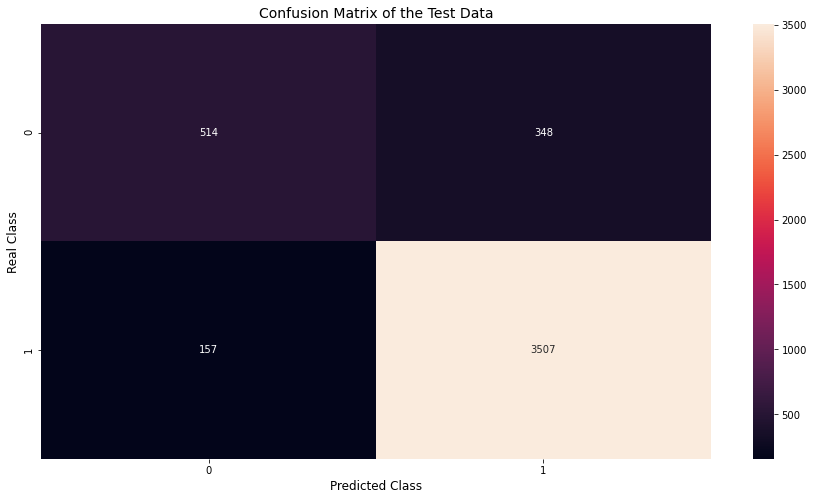

In [24]:
for i, x in enumerate(pred_test_lstm):
    if 0 <= x < 0.49:
        pred_test_lstm[i] = 0
    else:
        pred_test_lstm[i] = 1

for i, x in enumerate(pred_train_lstm):
    if 0 <= x < 0.49:
        pred_train_lstm[i] = 0
    else:
        pred_train_lstm[i] = 1

conf_mat = confusion_matrix(y_true=y_test, y_pred=pred_test_lstm)
plt.figure(figsize=(15, 8))
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.title('Confusion Matrix of the Test Data', fontsize=14)
plt.ylabel('Real Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

In [25]:
print(classification_report(y_test,pred_test_lstm))

              precision    recall  f1-score   support

           0       0.77      0.60      0.67       862
           1       0.91      0.96      0.93      3664

    accuracy                           0.89      4526
   macro avg       0.84      0.78      0.80      4526
weighted avg       0.88      0.89      0.88      4526



In [26]:
def predict_recommendation(input_text):  # The function for doing all the previous steps
    input_text = input_text.lower()
    input_text = re.sub(r'[^a-zA-Z]', ' ', input_text)
    input_text = tokenization(input_text)
    input_text = stopwords_remove(input_text)
    input_text = lemmatization(input_text)
    input_text = ' '.join(input_text)
    input_text = tokenizer.texts_to_sequences([input_text])
    input_text = pad_sequences(input_text, maxlen=maxlen, padding='pre')
    input_text = model.predict(input_text)
    if input_text >= 0.5:
        input_text = f'Recommended with %{round(float(input_text*100), 2)}'
    else:
        input_text = f'Not Recommended with %{round(float(input_text*100), 2)}'

    return print(input_text)

In [27]:
predict_recommendation("I'm so disapointed, the dress I bought is poor quality and was so expansive. I want a refound but it was impossible to go with it. I don't recommended this shop")

Not Recommended with %40.44


In [28]:
review1 = "I ordered this dress in 0p since i am 5ft. it fits great its not too short just above the knee."
review2 = "Love the top design, not so much the fabric. i should've read the top was 100% polyester. returning and finding a better quality top."
review3 = "Love this henely, the lace-up is cute. the shirt is comfy. so versatile. beach coverup or over jeans"
review4 = "Loved this dress online, but my small pettie stature made me looks like an orphan from the prairie."
review5 = "I tried it in the store but was not the true size so i ordered online. i wore it only once so far and got lots of compliments. very unique design."
review6 = "Nice shirt seems well made. good just not a great fit for me."
review7 = "I tried on this dress in store and was amazed by the quality and simple structure of the dress. bought it with no hesitation."
review8 = "This top has a bit of a retro flare but so adorable on. looks really cute with a pair of faded boot cut jeans."
review9 = "Great quality top. i do wish it fit me...i'm really long waisted and this top was too short. had to return"
review10 = "A serious joke. i struggled with the buttons for a good 10 minutes and gave up after the 3rd button. i'm not sure what they were thinking."

reviews = [review1, review2, review3, review4, review5, review6, review7, review8, review9, review10]

In [29]:
for i in reviews:
    a = predict_recommendation(i)  

Recommended with %78.58
Not Recommended with %27.82
Recommended with %99.21
Recommended with %62.01
Recommended with %98.39
Recommended with %84.99
Recommended with %95.45
Recommended with %97.27
Recommended with %59.62
Recommended with %57.49


In [30]:
a

In [31]:
predict_recommendation("This dress is perfection, I could wear all day and all night. I want to marry the shoper")

Recommended with %82.27


In [32]:
predict_recommendation("free britney bitch")

Recommended with %75.73


In [33]:
model.save('matthis_model.h5')

In [34]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)